#### Available Data

The **trip**-related dat apoints are the following:

* 'medallion',
* ' hack_license',
* ' vendor_id',
* ' rate_code',
* ' store_and_fwd_flag',
* ' pickup_datetime',
* ' dropoff_datetime',
* ' passenger_count',
* ' trip_time_in_secs',
* ' trip_distance',
* ' pickup_longitude',
* ' pickup_latitude',
* ' dropoff_longitude',
* ' dropoff_latitude'

and the **fare** CSV file contains the columns as below

* 'medallion',
* ' hack_license',
* ' vendor_id',
* ' pickup_datetime',
* ' payment_type',
* ' fare_amount',
* ' surcharge',
* ' mta_tax',
* ' tip_amount',
* ' tolls_amount',
* ' total_amount'

a. What is the distribution of number of passengers per trip? (trips)

b. What is the distribution of payment_type? (fares)

c. What is the distribution of fare amount? (fares)

d. What is the distribution of tip amount? (fares)

e. What is the distribution of total amount? (fares)

f. What are top 5 busiest hours of the day? (trips/fares)

g. What are the top 10 busiest locations of the city? (trips)

h. Which trip has the highest standard deviation of travel time? (trips)

i. Which trip has most consistent fares? (fares)

In [1]:
import pandas as pd
import re
import seaborn as sns
import arrow
import time
from collections import Counter, defaultdict

sns.set_style("whitegrid")

In [49]:
class Taxi:
    
    def __init__(self, trip_file, fare_file):
        
        self.trip_file = trip_file
        self.fare_file = fare_file
        
        self.distros = defaultdict(lambda: defaultdict(int))

    def get_distro(self, rows_at_once=10000):
        
        # trip is defined by (medallion, pickup_datetime)
        
        for i, d in enumerate(pd.read_csv('data/' + self.trip_file, chunksize=rows_at_once, 
                                          usecols=['medallion', ' pickup_datetime', ' passenger_count', ' pickup_longitude',
 ' pickup_latitude', ' dropoff_longitude', ' dropoff_latitude'])):
            for row in d.groupby(['medallion', ' pickup_datetime']).sum().iterrows():
                self.distros['passengers'][row[0]] += row[1][' passenger_count']
                self.distros['pickup_hrs'][arrow.get(row[0][1]).hour] += 1
                self.distros['pickup_loc'][(' pickup_latitude', ' pickup_longitude')] += 1
                
            if i%10 == 0:
                print(f'done {i*rows_at_once:,} rows..')
        
#         for i, d in enumerate(pd.read_csv('data/' + self.fare_file, chunksize=rows_at_once,
#                                           usecols=['medallion', ' pickup_datetime', ' fare_amount', ' tip_amount'])):
#             for row in d.groupby(['medallion', ' pickup_datetime']).sum().iterrows():
                
#                 self.distros['fare_amount'][row[0]] += row[1][' fare_amount']
#                 self.distros['tip_amount'][row[0]] += row[1][' tip_amount']
#                 self.distros['tip_amount'][row[0]] += row[1][' tip_amount']
                
#             if i%10 == 0:
#                 print(f'done {i*rows_at_once:,} rows..')
                
        return self

In [50]:
if __name__ == '__main__':
    
    tx = Taxi(trip_file='trip_data_4.csv', fare_file='trip_fare_4.csv').get_distro()

done 0 rows..
done 100,000 rows..
done 200,000 rows..
done 300,000 rows..
done 400,000 rows..
done 500,000 rows..
done 600,000 rows..
done 700,000 rows..
done 800,000 rows..
done 900,000 rows..
done 1,000,000 rows..
done 1,100,000 rows..
done 1,200,000 rows..
done 1,300,000 rows..
done 1,400,000 rows..
done 1,500,000 rows..
done 1,600,000 rows..
done 1,700,000 rows..
done 1,800,000 rows..
done 1,900,000 rows..
done 2,000,000 rows..
done 2,100,000 rows..
done 2,200,000 rows..
done 2,300,000 rows..
done 2,400,000 rows..
done 2,500,000 rows..
done 2,600,000 rows..
done 2,700,000 rows..
done 2,800,000 rows..
done 2,900,000 rows..
done 3,000,000 rows..
done 3,100,000 rows..
done 3,200,000 rows..
done 3,300,000 rows..
done 3,400,000 rows..
done 3,500,000 rows..
done 3,600,000 rows..
done 3,700,000 rows..
done 3,800,000 rows..
done 3,900,000 rows..
done 4,000,000 rows..
done 4,100,000 rows..
done 4,200,000 rows..
done 4,300,000 rows..
done 4,400,000 rows..
done 4,500,000 rows..
done 4,600,000

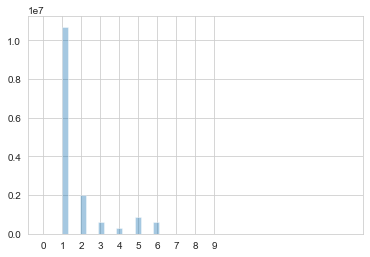

In [64]:
ax = sns.distplot(list(tx.distros['passengers'].values()), hist=True, kde=False, label='passengers').set_xticks(range(10))

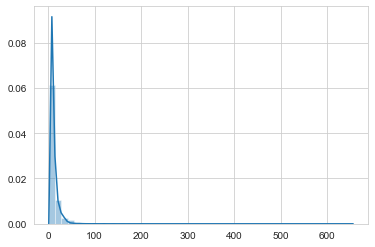

In [66]:
ax = sns.distplot(list(tx.distros['fare_amount'].values()), hist=True, kde=True, label='passengers')

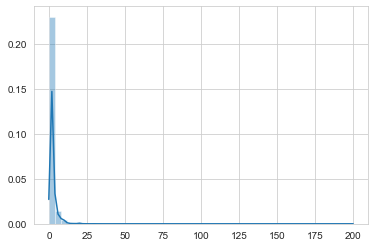

In [67]:
ax = sns.distplot(list(tx.distros['tip_amount'].values()), hist=True, kde=True, label='passengers')